In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data_path = '/Users/niloufar/Desktop/DeepLearning/tf_specialization/comment/'
data1 = 'spam_or_not1.xlsx'
data2 = 'spam_or_not2.xlsx'
data3 = 'spam_or_not3.xlsx'

df1 = pd.read_excel(data_path + data1)
df2 = pd.read_excel(data_path + data2)
df3 = pd.read_excel(data_path + data3)

df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.drop(['ID', df.columns[3]], axis=1)
df.head(18)

,Text (comment),Spam or ham
0,یه مشت لات و لوت جمع کردید تو این اتاق فرار و ...,Spam
1,سناریو اصلا خوب نبود و برای ما نصفه تموم شد - ...,Spam
2,رفتار پرسنل مناسب نبود\n عدم اگاهی رسانی دقیق...,Spam
3,😡😡😡هشدار این یک کلاه برداری علنی است😡😡😡\nخونه ...,Spam
4,اتاق فرار خوبی بود اما نه به اندازه کامنت ها ق...,Spam
5,سلام\nمجوز برای اتاق فرار نداشتند\nبرخورد خوب ...,Spam
6,داستان بازی سر و ته مشخصی نداشت،بیشتر فضا سازی...,Spam
7,در خصوص بازی های اتاق فرار با احترام به کسانی ...,Spam
8,نه مجوز\nنه کوچه مطمئن \nنه محله درست\nنه جای ...,Spam
9,افتضاح خواهشن به كامنت ها توجه نكنيد\nنميدونم ...,Spam


In [3]:
def remove_stopwords(sentence):
    stopwords = ['که', 'در', 'از', 'به', 'و', 'را', 'این', 'آن', 'بعد', 'همه', 'دوباره', 'یک', 'یه', 'من', 'تو', 'او', 'ما', 'شما', 'قبل', 'آنها', 'زیرا', 'زیر', 'اما', 'بین', 'دو', 'با', 'اونجا',
                'برای', 'حتما','حالی', 'چرا', 'چی', 'ازطریق', 'رو', ',', 'واقعا','ها', 'تو', 'اون', 'ترین', 'توی', 'چه', 'مارو', 'سر', 'اونجا', 'خود', 'هارو', 'آقا', 'همتون', 'هام', 'دوتا', 'دوباره',
                'اگه', 'ولی', 'روش', 'اینو', 'هنوز', 'ده', 'سه', 'چهار', 'پنج', 'شش', 'هفت', 'هشت', 'نه', 'ده', 'نا','ایی']
    words = sentence.split()
    results_words = [word for word in words if word not in stopwords]
    sentence = ' '.join(results_words)
    return sentence

In [4]:
remove_stopwords("پدر سگ را به درخت بست.")

'پدر سگ درخت بست.'

### Reading the raw data

In [5]:
def parse_data_from_file(file):
    sentences = []
    labels = []
    for i,j in zip(df[df.columns[0]], df[df.columns[1]]):
        sentences.append(remove_stopwords(i))
        labels.append(j)
    return sentences, labels
        

In [6]:
sentences, labels = parse_data_from_file(df)

In [7]:
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 6235 sentences in the dataset.

First sentence has 83 words (after removing stopwords).

There are 6235 labels in the dataset.

The first 5 labels are ['Spam', 'Spam', 'Spam', 'Spam', 'Spam']


In [8]:
NUM_WORDS = 10000 #13861
EMBEDDING_DIM = 64
MAXLEN = 120 #608
PADDING = 'post'
OOV_TOKEN = '<OOV>'
TRAINING_SPLIT = .8

### Training - Validation Split

In [9]:
def train_val_split(sentences, label_seq_np, training_split):
    train_size = int(len(sentences)*training_split)
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]
    
    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]
    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 4988 sentences for training.

There are 4988 labels for training.

There are 1247 sentences for validation.

There are 1247 labels for validation.


### Using the Tokenizer

In [39]:
train_labels.count('spam')

218

In [12]:
def fit_tokenizer(sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [13]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(tokenizer.word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in tokenizer.word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 12536 words

<OOV> token included in vocabulary


In [18]:
def seq_and_pad(tokenizer, sentences, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen)
    return padded_sequences

In [19]:
train_padded_seq = seq_and_pad(tokenizer,train_sentences, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(tokenizer, val_sentences, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (4988, 120)

Padded validation sequences have shape: (1247, 120)


In [20]:
def tokenize_labels(all_labels, split_labels):
    label_tokenizer = Tokenizer()
    label_tokenizer.fit_on_texts(all_labels)
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    label_seq_np = np.array(label_seq) - 1
    
    return label_seq_np

In [21]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[1]
 [1]
 [1]
 [1]
 [1]]

First 5 labels of the validation set should look like this:
[[0]
 [0]
 [0]
 [0]
 [0]]

Tokenized labels of the training set have shape: (4988, 1)

Tokenized labels of the validation set have shape: (1247, 1)



### Selecting the model for text classification

In [26]:
def create_model(num_words, embedding_dim, maxlen):
    
    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=MAXLEN),
#         tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(6, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [27]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 64)           640000    
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 46086     
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 686,093
Trainable params: 686,093
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30


2023-05-06 09:01:56.616434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 4s 21ms/step - loss: 0.3666 - accuracy: 0.8569 - val_loss: 0.0970 - val_accuracy: 0.9984
Epoch 2/30
  1/156 [..............................] - ETA: 3s - loss: 0.2527 - accuracy: 0.9062

2023-05-06 09:01:59.988626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 3s 19ms/step - loss: 0.1956 - accuracy: 0.9294 - val_loss: 0.0479 - val_accuracy: 0.9872
Epoch 3/30
156/156 [==============================] - 3s 18ms/step - loss: 0.1199 - accuracy: 0.9563 - val_loss: 0.0563 - val_accuracy: 0.9840
Epoch 4/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0718 - accuracy: 0.9743 - val_loss: 0.0421 - val_accuracy: 0.9880
Epoch 5/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0424 - accuracy: 0.9880 - val_loss: 0.0426 - val_accuracy: 0.9856
Epoch 6/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0266 - accuracy: 0.9932 - val_loss: 0.0612 - val_accuracy: 0.9816
Epoch 7/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0962 - val_accuracy: 0.9727
Epoch 8/30
156/156 [==============================] - 3s 17ms/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.0864 - val_accuracy: 0.9775
Epoch 9/30

In [40]:
model.predict(train_padded_seq[1:10])

1/1 [==============================] - 0s 17ms/step


array([[0.99997795],
       [0.9999356 ],
       [0.99999475],
       [0.9999232 ],
       [0.99977916],
       [0.99997175],
       [0.9999927 ],
       [0.9999682 ],
       [0.99999976]], dtype=float32)

In [34]:
val_label_seq[1:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [38]:
val_labels.count('spam')

0

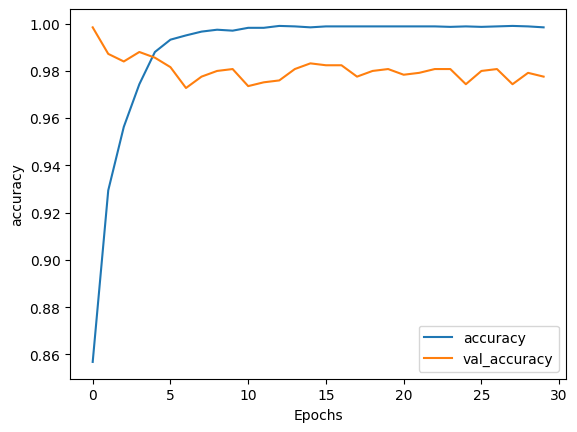

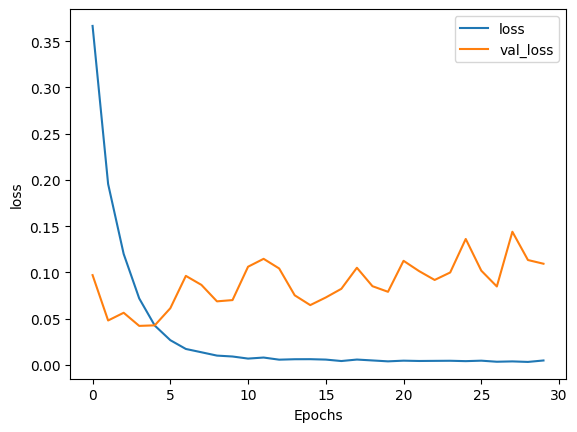

In [36]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")   